# Event marking for epoching data

1. load data
2. inspect raw channels (drop bads?)
3. re-reference, filter, & downsample
3. epoch into event-related trials
4. inspect trials for interictal events?
4. 

https://mne.tools/stable/auto_tutorials/clinical/30_ecog.html

https://mne.tools/dev/auto_tutorials/clinical/20_seeg.html

https://www.sv.uio.no/psi/english/research/projects/human-time-data/documents/data-lifecycle/ieeg/resources/ieeg-doc-firstdraft.pdf

https://www.fieldtriptoolbox.org/tutorial/human_ecog/

https://www.fieldtriptoolbox.org/example/rereference/

In [1]:
# imports
import numpy as np
import scipy.io as sio
import scipy as sp
import pandas as pd
import mne
import mne_bids

from neurodsp import spectral
from neurodsp import filt

import matplotlib.pyplot as plt
%matplotlib qt

## 1. Load data

In [2]:
path = '/Users/sydneysmith/Projects/PrOPHEcy/iEEG_BIDS'

In [3]:
# first define the bids path
bids_path = mne_bids.BIDSPath(root=path, subject='1002', task='PrOPHEcy', datatype='ieeg', extension='edf') # task = 'PrOPHEcy'?

# make raw object
raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

# Pick only the ECoG channels, removing the EKG channels
raw.pick_types(seeg=True, stim=True)

# Load the data
raw.load_data()

Reading 0 ... 1234047  =      0.000 ...  2410.248 secs...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_9962/2891083385.py:5: RuntimeWarning: The unit for channel(s) DC1, TRIG has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)


<RawEDF | sub-1002_task-PrOPHEcy_ieeg.edf, 144 x 1234048 (2410.2 s), ~1.32 GB, data loaded>

Effective window size : 0.977 (s)


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_9962/3483039928.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=1945.0, tmax=1955.0, n_fft=500, n_overlap=0.5, xscale='log')


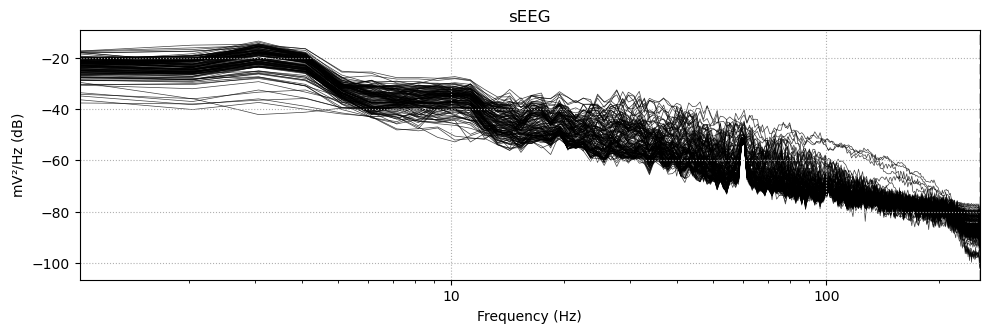

In [15]:
raw.plot_psd(tmin=1945.0, tmax=1955.0, n_fft=500, n_overlap=0.5, xscale='log')
# plt.xscale('log')

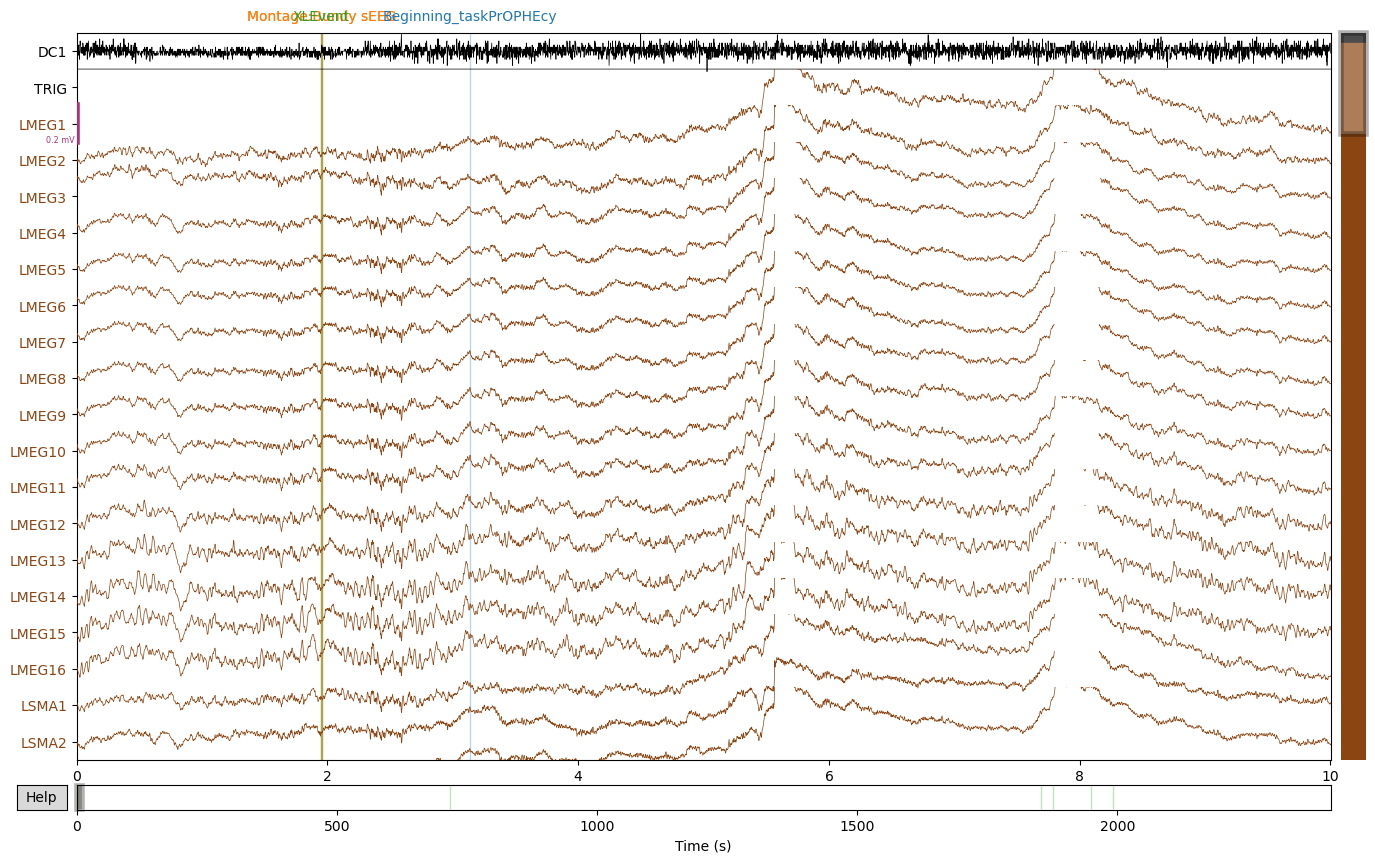

In [16]:
raw.plot()


## Epoching

Use manually-annotated data and secondary audio channel (DC1) to get precise onsets of stimuli. Overcomes issue with hardware (skipped, jittered triggers)

In [18]:
# import annotated file
raw_annot = mne.io.read_raw_fif('FIF_dat/complete/1004_events_artifacts_raw.fif', preload=True)

Opening raw data file FIF_dat/complete/1004_events_artifacts_raw.fif...
Isotrak not found
    Range : 0 ... 2402047 =      0.000 ...  2345.749 secs
Ready.
Reading 0 ... 2402047  =      0.000 ...  2345.749 secs...


In [14]:
len(raw_annot.info['ch_names'])

144

#### scalings

1004
scalings={'seeg' : 150e-6}

1002
scalings={'seeg' : 100e-6}

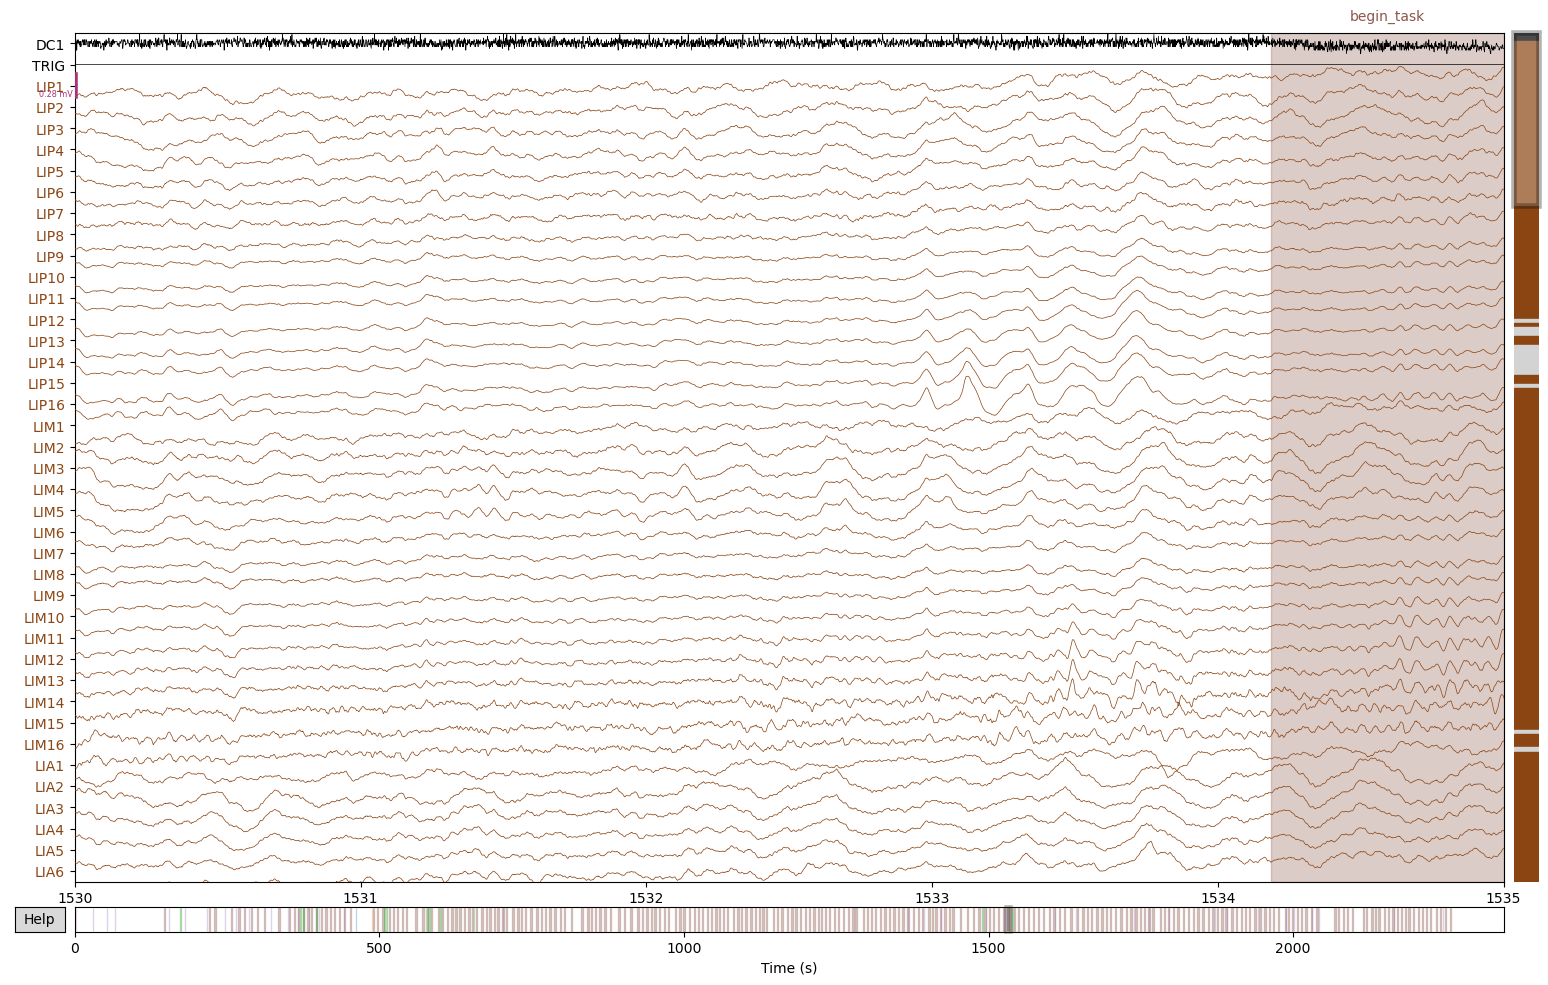

Channels marked as bad: ['RMT1', 'RMT3', 'RMT4', 'RMT7', 'RMT9', 'RMT8', 'RMT10', 'RMT11', 'RMT12', 'RMT13', 'RMT16', 'MF8', 'AST4']


In [20]:
# plot
scalings={'seeg' : 140e-6}
raw_annot.plot(scalings=scalings, n_channels=40, clipping=None, start=1530, duration=5.0)

In [9]:
raw_annot.set_eeg_reference('average')

sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.


<Raw | 1005_events_artifacts_raw.fif, 170 x 2237056 (2184.6 s), ~2.83 GB, data loaded>

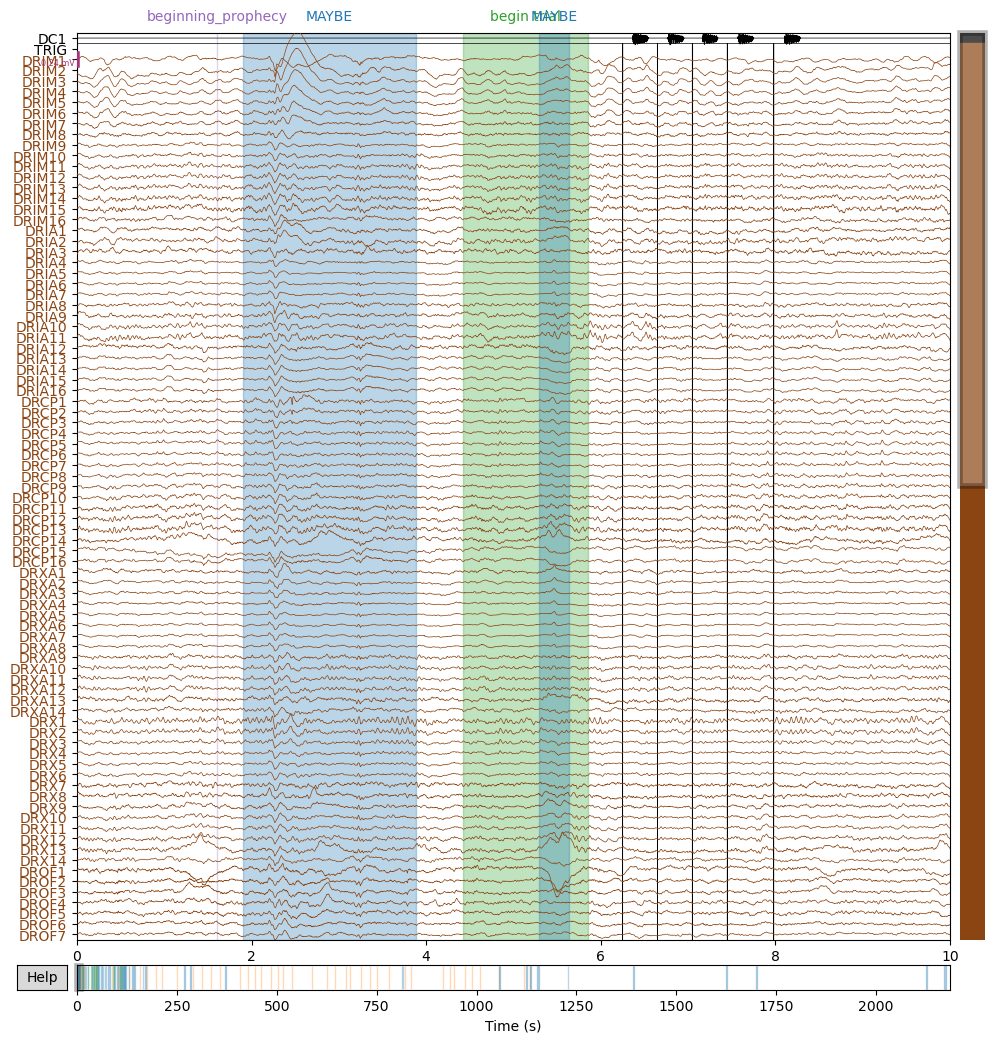

In [10]:
raw_annot.plot(scalings=scalings, n_channels=85, clipping=None)

In [7]:
#raw_annot.save('FIF_dat/complete/1002_events_artifacts_raw.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Writing /Users/sydneysmith/Projects/iEEGPreprocessing/FIF_dat/complete/1002_events_artifacts_raw.fif
Closing /Users/sydneysmith/Projects/iEEGPreprocessing/FIF_dat/complete/1002_events_artifacts_raw.fif
[done]


In [7]:
len(raw_annot.info['ch_names'])

196

In [6]:
# extract annotation descriptions and onsets
onsets = raw_annot.annotations.onset
descriptions = raw_annot.annotations.description

In [7]:
# get data from DC1 and trigger channels
dc1 = raw_annot.get_data(picks='DC1').flatten()
trig = raw_annot.get_data(picks='TRIG').flatten()

In [8]:
list(descriptions).count('begin_trial') # sanity check, should be 16

16

In [9]:
# get lists of missing onsets and trial onsets

missing_onsets = []
trial_onsets = []

for i, ann in enumerate(descriptions):
    if ann[0] == 'm':
        missing_onsets.append(onsets[i])
    if ann[0] == 'b':
        trial_onsets.append(onsets[i])

In [10]:
# normalize trigger channel (MNE event detection works best when stimulus channel is zero/non-zero)

norm_trig = trig + abs(trig[0])
norm_trig = abs(norm_trig)
norm_trig

array([0., 0., 0., ..., 0., 0., 0.])

In [1]:
# make new trigger channel with coded onsets for different events
# 1 = normal triggers, 2 = missing triggers, 3 = trial onsets

trig_ind = sp.signal.find_peaks(norm_trig)[0] #np.where(norm_trig!=0)
new_trig = np.zeros_like(norm_trig)
for ind in trig_ind:
    new_trig[ind] = 1.
    
for onset in missing_onsets:
    ind = int(onset*raw_annot.info['sfreq'])
    new_trig[ind] = 2.
    
for begin_trial in trial_onsets:
    ind = int(begin_trial*raw_annot.info['sfreq'])
    new_trig[ind] = 3.

NameError: name 'sp' is not defined

In [ ]:
# add new_trig as a channel to MNE raw

info = mne.create_info(['STI'], raw_annot.info['sfreq'], ['stim'])
new_trig = np.reshape(new_trig, [1,87302])
stim_raw = mne.io.RawArray(new_trig, info)
raw_annot.add_channels([stim_raw], force_update_info=True)

In [2]:
# plot annotated data with added stimulus channel

raw_annot.plot()

NameError: name 'raw_annot' is not defined

In [19]:
# filter, hilbert DC1 channel in narrowband frequency for audio stimulus envelope

dc1_filt = filt.filter_signal(dc1, fs=raw_annot.info['sfreq'], pass_type='bandpass', f_range=[45,50], remove_edges=False)
dc1_hilb = np.abs(sp.signal.hilbert(dc1_filt))    

/Users/sydneysmith/opt/anaconda3/lib/python3.7/site-packages/neurodsp/filt/checks.py:173: UserWarning: Transition bandwidth is  13.8  Hz. This is greater than the desiredpass/stop bandwidth of  5.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))


In [21]:
# in new trigger channel, get indices of triggers in array

peaks = new_trig[new_trig>0]
peak_ind = np.where(new_trig>0)[1] # known triggers
#peak_ind_missing = np.where(new_trig==2.) #missing

In [15]:
# plot new trigger channel

x = np.linspace(0, 170, len(new_trig.flatten()))

plt.plot(x, new_trig.flatten())

In [23]:
# create events array (shape = n_events, 3) from new trigger channel and z-scored amplitude envelope of DC1 channel

events_arr = []

new_trig = new_trig.flatten()

# zscore amplitude envelope based on samples 500-1000 as baseline (avoids any weirdness around filter artifacts)
zscore = abs(((dc1_hilb)-np.mean(dc1_hilb[500:1000]))/np.std(dc1_hilb[500:1000]))

for n in range(len(peak_ind)):
    this_ind = peak_ind[n]
    if new_trig[this_ind] == 3.: # trial beginning (event code = 10)
        trialOnset = this_ind
        events_arr.append([this_ind, 0, 10])
    elif (new_trig[this_ind]==1) or (new_trig[this_ind]==2):
        mostRecentEv = events_arr[-1][2] # get most recent event ID before the peak
        mostRecentT = events_arr[-1][0] # get most recent event onset
        
        if mostRecentEv == 10: # 1st tone
            evID = 1
        elif mostRecentEv == 1: # 2nd tone
            evID = 2
        elif mostRecentEv ==2: # 3rd tone
            evID = 3
        elif mostRecentEv == 3: # 4th tone
            evID = 4
        elif mostRecentEv ==4: # 5th tone
            evID = 5
            
        # get 0.21 second window around peak from zscored DC1 data
        # find events where DC1 amp envelope passed z=10
        win = zscore[this_ind:int(this_ind+0.21*raw_annot.info['sfreq'])]  
        thresh = 10.0
        evOnset = np.where(win>thresh)[0][0] + this_ind
        
        # if onset of most recent event ??
        if mostRecentT+10 < evOnset:
            events_arr.append([evOnset, 0, evID])
        else: 
            pass
    

In [25]:
# make events array list into 
events_arr = np.asarray(events_arr)

In [26]:
events_arr_target = events_arr.copy()

# loop and replace all target tones with 5
for i in range(len(events_arr_target)):
    this_ev = events_arr_target[i]
    if (this_ev[2] == 10) and (i!=0):
        events_arr_target[i-1][2] = 5
        
events_arr_target[-1][2] = 5

In [ ]:
# check events array, last tone in each trial (target tone) should be 5
events_arr_target

In [27]:
# create epochs object using events array
epochs = mne.Epochs(raw_annot, events_arr_target, event_id={'first_tone': 1},
                    tmin=-0.8, tmax=5.0, picks=['seeg', 'stim'])

Not setting metadata
Not setting metadata
16 matching events found
Setting baseline interval to [-0.80078125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Loading data for 15 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 original time points ...
Loading data for 1 events and 2971 orig

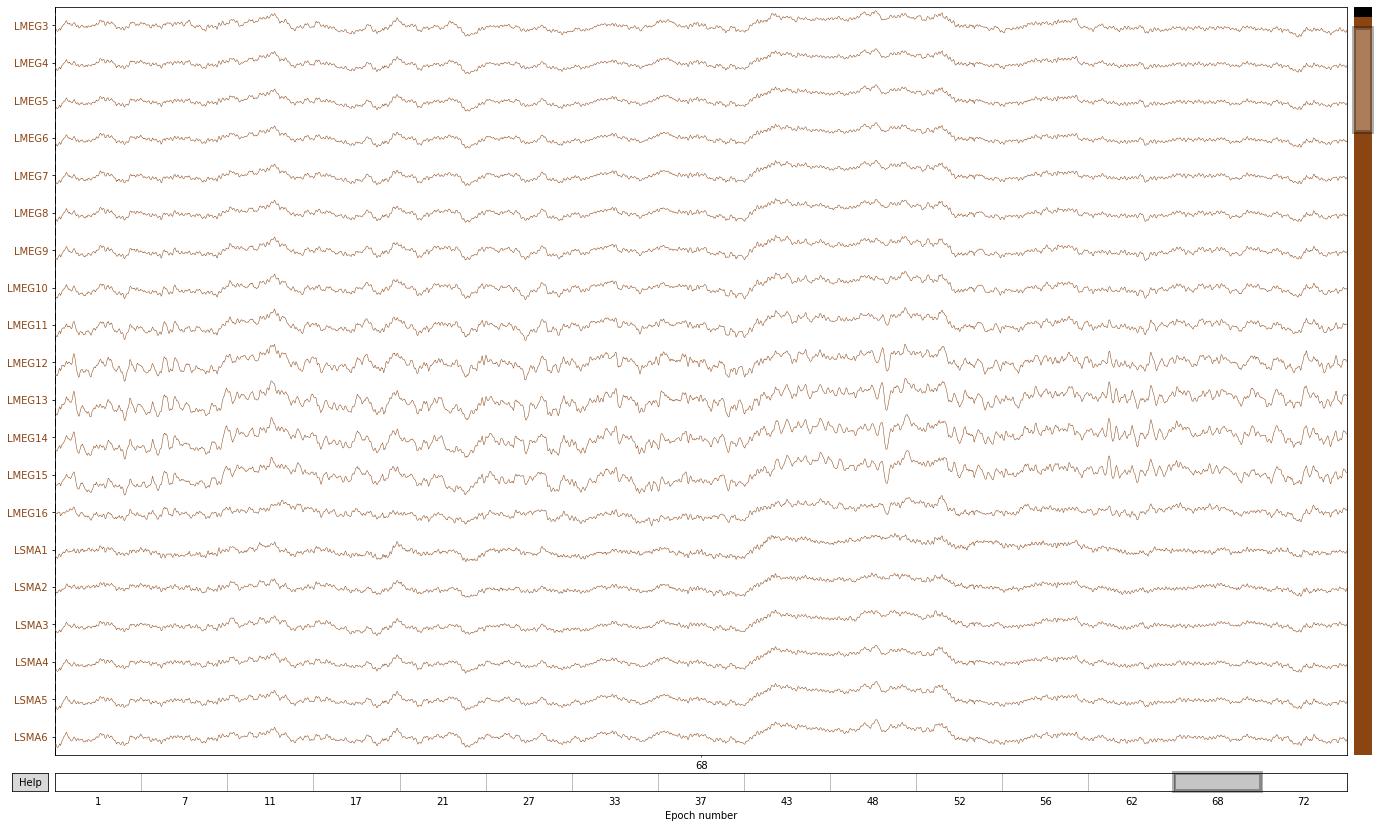

In [31]:
epochs.plot(picks=['seeg', 'stim'], block=True, n_epochs=1)

# YAAAAY :)

Manual Artifact rejection

In annotated (events) raw object
1) mark suspiscious activity (MAYBE)
2) decide which maybes are bad, mark with new label (bad)
3) epoch, reject_by_annotation=True


Adding behavioral metadata
- do before rejecting epochs
- sanity check on trigger annotation process
- MNE adds metadata to epochs based on behav csv
- as example of "this is when and how," not generalizable pipeline

In [ ]:
# save events array to BIDS object

### data exploration

Effective window size : 4.000 (s)


<ipython-input-9-b92cd71cbcf7>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=raw.info['ch_names'][0:16], fmax=150 );


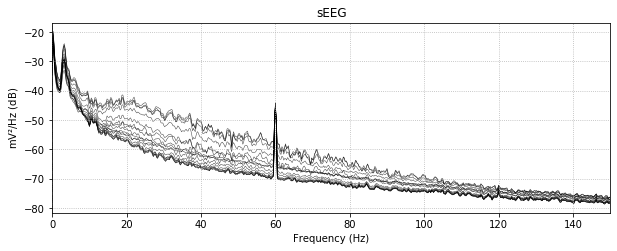

In [9]:
raw.plot_psd(picks=raw.info['ch_names'][0:16], fmax=150 );

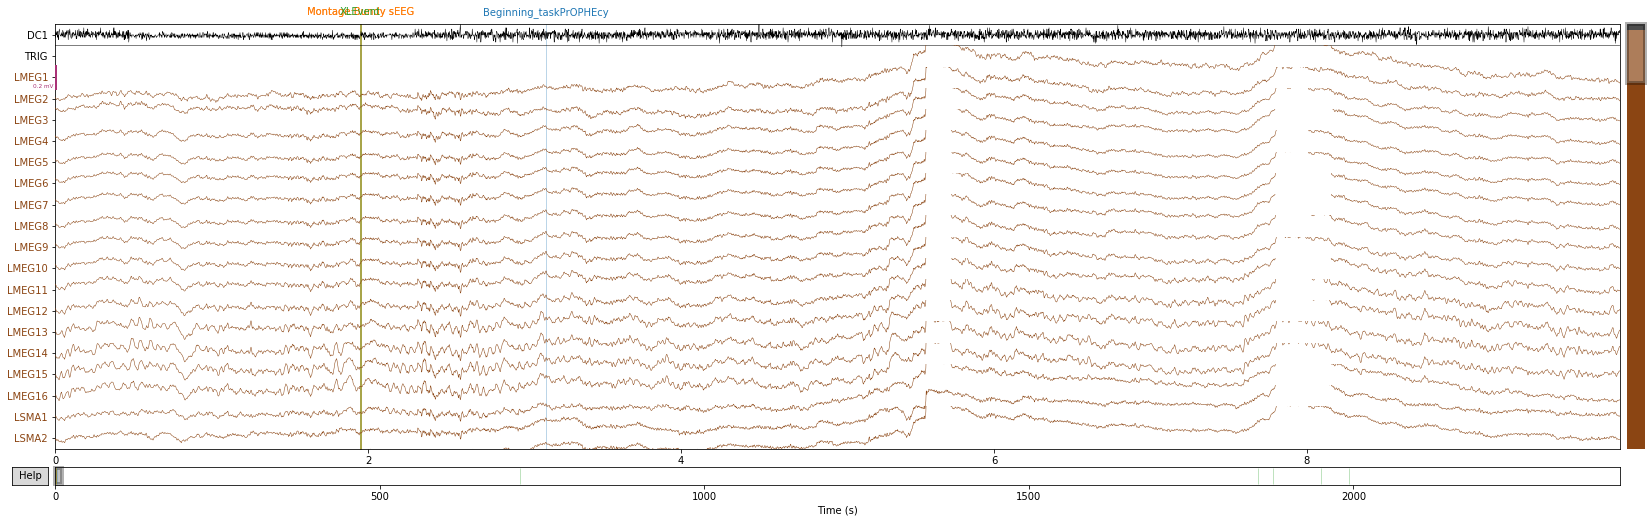

In [123]:
raw.plot()

In [26]:
mne.find_events(raw, stim_channel='TRIG', output='offset')

array([], shape=(0, 3), dtype=int32)

In [9]:
trig = raw.get_data(picks='TRIG')

In [21]:
norm_trig = trig + abs(trig[0])

In [22]:
norm_trig

array([[0., 0., 0., ..., 0., 0., 0.]])

# epoching
- event onset from trigger
- rectify with DC1 (or hilbert, unfiltered)

# artifact detection
- garbage trials manually (minimize false positives for noise rejection)
- if more than x channels have values 2std, FLAG (iterate) --> then manual

# rereferencing
- find clinical notes of reference electrode
- not common avg
- common avg per shank if necessary
- @bender -- spatial rereferencing in iEEG w/Natalie

# filtering
- medical equipment frequencies 
- look at power spectra after referencing

# data exploration
- plot, explore, spectra

# Meta-teaching
- save example trials for training primer


In [124]:
raw.plot(start=1800);

In [125]:
raw.info['bads']

[]

Channels marked as bad: ['LMEG1']


In [126]:
raw.info['bads']

['LMEG1']